# Multi-class Classification

在这次作业中，将使用 one-vs-all logistic regression 和 neural networks 来识别手写数字

In [140]:
# 引入包
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.ma.core import shape
from scipy.io import loadmat

##  Dataset
一共含有5000个训练样本。 每个数据都是20 * 20的灰度图。 每个像素(pixel)由一个浮点数表示，该浮点数表示该位置的灰度强度。 20 × 20 的像素网格被“展开”为400维向量。 每一个例子作为一个单独的行向量。 X 是一个5000 * 400 的矩阵，每行都是一个训练样本。

$$
X = \begin{bmatrix}
 -{x^{(1)}}^T  \\
 -{x^{(2)}}^T  \\
 \vdots        \\
  -{x^{(m)}}^T
\end{bmatrix}
$$

## Visualizing the data

In [141]:
def load_data(path):
    data = loadmat(path)
    print(data)
    X = data['X']
    y = data['y']
    print('X:',X)   # 图片
    print('y:',y)   # 标签， 其中y会出现10是因为：
                    #   1对应1 ... 9对应9， 0对应10
    return X, y

In [142]:
X_raw, y_raw = load_data('ex3data1.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}
X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y: [[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]


In [143]:
X_raw.shape, y_raw.shape

((5000, 400), (5000, 1))

测试一个图片


In [144]:
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape(20, 20), cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

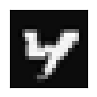

this should be [2]


In [145]:
random_one = np.random.randint(0,5000)
plot_an_image(X_raw[random_one, :])
print('this should be {}'.format(y_raw[random_one]))

## Vectorizing Logistic Regression

using multiple one-vs-all logistic regression models to build a multi-class classifier.

### 数据准备

![Vectorized_Labels from https://github.com/Sanzo00](./20250422185853.png)

我们的任务是实现 one vs all 全分类方法，其中具有k个不用类的标签就要有k个分类器，每个分类器在“类i”与“非类i”之间选择。
将y进行向量化，从类标签转换为每个分类器的二进制值（类i or 非类i）。

In [146]:
label_num = np.unique(y_raw)
label_num

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [147]:
y_raw

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped the digit \0" to the label 10 (to avoid confusions with indexing).

In [148]:
y = []
for i in range(1, label_num.size + 1):
    y.append([1 if label == i else 0 for label in y_raw])

# 此时的y是 1 2 3 ... 9 0; 要把最后一行给移动到最上面，然后按序下移
y = np.roll(np.array(y), shift=1, axis=0)

y.shape

(10, 5000)

In [149]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [150]:
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)
X.shape

(5000, 401)

### Logistic Regression 的函数

In [163]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(theta, X, y):
    h = sigmoid(X @ theta.T)

    cost_positive = y * np.log(h)
    cost_negative = (1 - y) * np.log(1 - h)

    return - np.mean(cost_positive + cost_negative)

def gradient(theta, X, y):
    return X.T @ (sigmoid(X @ theta.T) - y) / len(X)

### Regularized Logistic Regression 的函数

In [167]:
def cost_reg(theta, X, y, lambda_=1):
    return cost(theta, X, y) + lambda_ / (2 * len(X)) * sum(theta[1:] ** 2)

def gradient_reg(theta, X, y, lambda_=1):
    reg = theta * lambda_ / len(X)
    reg[0] = 0
    return gradient(theta, X, y) + reg

In [168]:
import scipy.optimize as opt

def logistic_regression(X, y, lambda_=1):
    theta = np.zeros(X.shape[1])
    res = opt.minimize(fun = cost_reg, x0=theta, args=(X, y, lambda_), method='TNC', jac=gradient_reg, options={'disp': True})
    return res.x

In [169]:
def predict(theta, X):
    prob = sigmoid(X @ theta)
    return (prob >= 0.5).astype(int)

## 预测分析

### 训练1维

In [170]:
theta_0 = logistic_regression(X, y[0])

  NIT   NF   F                       GTG
    0    1  6.931471805599454E-01   2.88474253E+00
    1    6  7.682547361206926E-02   4.04825829E-03
    2   16  3.249040729798806E-02   3.05111901E-04
tnc: fscale = 57.2493
    3   24  2.335425680275388E-02   4.04863529E-05
    4   27  2.161762796987874E-02   6.01012422E-06
    5   33  2.056839009526991E-02   1.33369216E-06
    6   41  2.019073771363374E-02   2.09434797E-07
tnc: fscale = 2185.12
    7   49  2.015519767948559E-02   6.38170939E-08
    8   59  2.014904461115180E-02   2.76315281E-09
    9   68  2.014803419235399E-02   7.06847203E-10
   10   77  2.014770111288744E-02   3.53577322E-10
tnc: fscale = 53181.2
   11   85  2.014756082366079E-02   1.02892820E-09
   12   94  2.014754323000393E-02   7.11674487E-11
tnc: |fn-fn-1] = 3.0964e-09 -> convergence
   13  103  2.014754013360552E-02   1.27149190E-12
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [171]:
from sklearn.metrics import classification_report
y_pred = predict(theta_0, X)
print('Accurary = {}'.format(np.mean(y[0] == y_pred)))

Accurary = 0.9974


### 训练k维

In [175]:
theta_k = np.array([logistic_regression(X, y[k]) for k in range(label_num.size)])
theta_k.shape

  NIT   NF   F                       GTG
    0    1  6.931471805599454E-01   2.88474253E+00
    1    6  7.682547361206926E-02   4.04825829E-03
    2   16  3.249040729798806E-02   3.05111901E-04
tnc: fscale = 57.2493
    3   24  2.335425680275388E-02   4.04863529E-05
    4   27  2.161762796987874E-02   6.01012422E-06
    5   33  2.056839009526991E-02   1.33369216E-06
    6   41  2.019073771363374E-02   2.09434797E-07
tnc: fscale = 2185.12
    7   49  2.015519767948559E-02   6.38170939E-08
    8   59  2.014904461115180E-02   2.76315281E-09
    9   68  2.014803419235399E-02   7.06847203E-10
   10   77  2.014770111288744E-02   3.53577322E-10
tnc: fscale = 53181.2
   11   85  2.014756082366079E-02   1.02892820E-09
   12   94  2.014754323000393E-02   7.11674487E-11
tnc: |fn-fn-1] = 3.0964e-09 -> convergence
   13  103  2.014754013360552E-02   1.27149190E-12
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  6.931471805599454E-01   3.58944746E+00
    1   

(10, 401)

In [177]:
prob_matrix = sigmoid(X @ theta_k.T)
np.set_printoptions(suppress=True)  # 抑制科学计数法,强制使用定点小数格式
prob_matrix

array([[0.99577475, 0.        , 0.00053487, ..., 0.00006469, 0.00003911,
        0.00172233],
       [0.99834684, 0.0000001 , 0.00005606, ..., 0.0000968 , 0.0000029 ,
        0.00008493],
       [0.99139745, 0.        , 0.00056857, ..., 0.00000655, 0.02652476,
        0.00197492],
       ...,
       [0.00000068, 0.04138112, 0.00320788, ..., 0.00012715, 0.00297529,
        0.70773894],
       [0.00001843, 0.00000013, 0.00000009, ..., 0.0016482 , 0.06818171,
        0.86123389],
       [0.02879765, 0.        , 0.00012982, ..., 0.36615316, 0.00497954,
        0.14825668]])

In [178]:
y_pred = np.argmax(prob_matrix, axis=1) # 返回每行最大的列索引
y_pred = np.array([10 if i == 0 else i for i in y_pred])
y_pred

array([10, 10, 10, ...,  9,  9,  7])

In [180]:
print(classification_report(y_raw, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

